In [101]:
# Allow interactive plots
%matplotlib widget
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1' # This avoids crashes on the math cluster from using to many resources
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from scipy import stats
from matplotlib import animation
import copy
import sys



from os.path import exists

# insert at 1, 0 is the script path (or '' in REPL)
# sys.path.insert(1, '/home/marius/PhD/CellMotility/analysis/')
from analysis_library import *


In [176]:
parameterFile = "/home/marius/PhD/CellMotility/agent_simulation/output_delayed_CIL/RDF/A_0.8_Pe_120"

"""Reads a previously written file containing a multidimensional histogram. It assumes that the histogram is 
in the same folder as the parameterFile and is named parameterFile+"_histogram_delta.csv"""
sim = experiment("sim")
sim.periodic = True
params = sim.read_parameter_file(parameterFile)
maxLength = sim.set_max_distance()

In [177]:

with open(parameterFile+"_histogram_delta.csv", 'r') as f:
    csvFile = csv.reader(f, delimiter=" ")
    for line in csvFile:
        if(line[0]=="Frequency,"): continue
        elif(line[0]=="binWidths:"): #Initialise the histogram and parameters
            print(line)
            rBinWidth = float(line[1])
            theta1BinWidth = float(line[2])
            theta2BinWidth = float(line[3])
            nTimes = float(line[4])
            
            nRBins = int(np.ceil(maxLength/rBinWidth)) #Only positive values
            nTheta1Bins = int(np.ceil(2*np.pi/theta1BinWidth)) 
            nTheta2Bins = int(np.ceil(2*np.pi/theta2BinWidth))
            histogram = np.zeros((nRBins, nTheta1Bins, nTheta2Bins, 3)) 

        else:
            # Distance, theta1 = phiR-phi1, theta2 = phi2-phi1, typeIdx, time
            # type has: 0 (both red), 1 (both green), 2 (green-red pair)
            
            histogram[  int(float(line[1])), 
                        int(float(line[2])), 
                        int(float(line[3])),
                        int(float(line[4]))] = int(float(line[0]))
            
cpy = histogram 
histogram.shape
histogram.min()
histogram.max()

['binWidths:', '0.5', '0.2617993877991494', '0.2617993877991494', '5', '']


28476.0

In [104]:
# Reference histogram
nReferencePoints = 6000
sim.periodic = True
referenceHistogram = sim.generate_reference_histogram(nReferencePoints,nRBins) #No angular distribution
referenceHistogram.min()
ref_cpy = referenceHistogram

In [178]:
histogram = cpy
referenceHistogram = ref_cpy
histogram.max()

28476.0

In [179]:
# Marginalize the distribution (needs to go from last to first index)
# Distance, theta1 = phiR-phi1, theta2 = phi2-phi1, typeIdx
# Type: 0 - red&red 1 - green&green 2 - red&green

# histogram = histogram[:,:,:,2] #Select pair types
histogram = np.sum(histogram, 3)
histogram = np.sum(histogram, 2) #Average over theta2
# histogram = np.sum(histogram, 1) #Average over theta1
histogram.shape
histogram.max()

821393.0

In [180]:
# Create bin
rBins = np.linspace(0, maxLength, nRBins+1)[:-1] + rBinWidth #Center of each bin
theta1Bins = np.linspace(0, 2*np.pi, nTheta1Bins+1)[:-1] + theta1BinWidth


821393.0

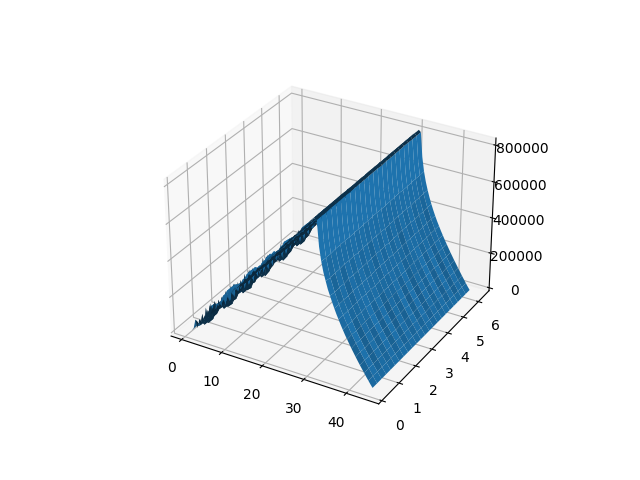

In [181]:
# Plot unnormalised densitites
fig3D = plt.figure()
ax3D = plt.axes(projection="3d")
X = np.outer(rBins, np.ones(1))
Y = np.outer(np.ones(1), theta1Bins)
ax3D.plot_surface(X, Y, histogram, label="reference")

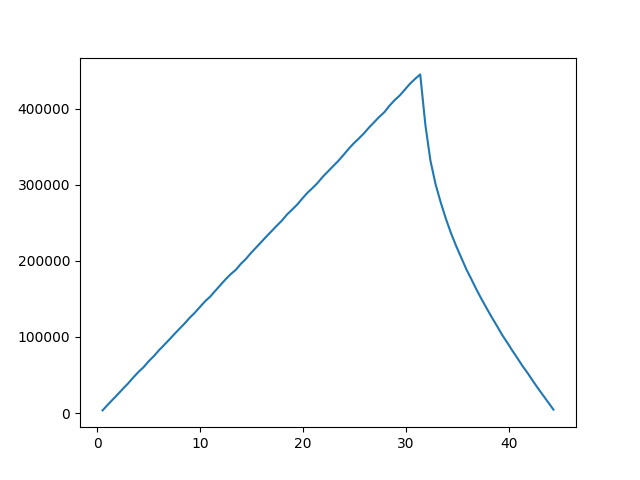

In [183]:
# Plot unnormalised densitites
fig, ax = plt.subplots(1,1)
ax.plot(rBins, referenceHistogram)

In [184]:
# Cutoff all values that are in the corners 
cutoff = int(maxLength/np.sqrt(2)/rBinWidth)
histogram = histogram[0:cutoff]
referenceHistogram = referenceHistogram[0:cutoff]

# Create bins
rBins = np.linspace(0, maxLength, cutoff+1)[:-1] + rBinWidth #Center of each bin
theta1Bins = np.linspace(0, 2*np.pi, nTheta1Bins+1)[:-1] + theta1BinWidth

In [185]:
# Normalise the radial and angular density
nReferenceValues = (nReferencePoints-1)*(nReferencePoints)/2
nValues = np.sum(histogram)
normalisedHistogram = np.zeros((cutoff, nTheta1Bins)) 
for idx in range(nTheta1Bins):
    normalisedHistogram[:,idx] = histogram[:,idx]/referenceHistogram
normalisedHistogram = normalisedHistogram*nReferenceValues/nValues

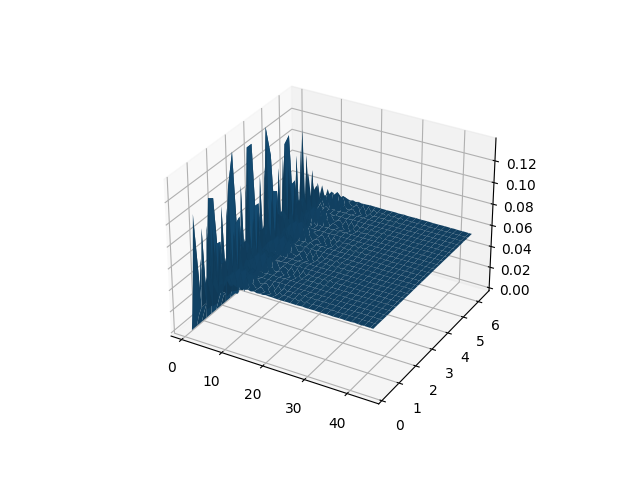

In [187]:
# Plot normalised densitites
fig3D = plt.figure()
ax3D = plt.axes(projection="3d")
X = np.outer(rBins, np.ones(1))
Y = np.outer(np.ones(1), theta1Bins)
ax3D.plot_surface(X, Y, normalisedHistogram, label="data")
fig3D.savefig(parameterFile+"_histogram_theta1.pdf",dpi=500)

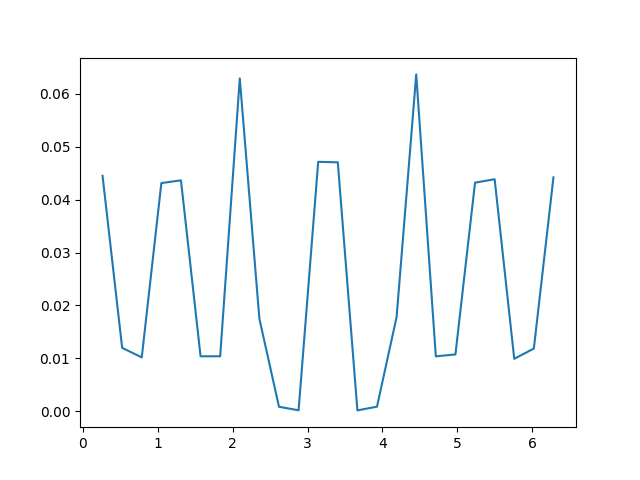

In [192]:
slice=1
fig, ax = plt.subplots(1,1)
ax.plot(theta1Bins,normalisedHistogram[slice])
fig.savefig(parameterFile+f"_histogram_theta1_slice_{slice}.png",dpi=500)